In [29]:
import yfinance as yf
import pandas as pd
import numpy as np
import re

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import set_style


## import model objects
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [30]:
df= pd.read_csv("../../Data and data related codes/dataset_reg.csv")

In [31]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
# df

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import mean_squared_error
import datetime


end_date = df['Date'].max()
start_date = end_date - pd.DateOffset(months=2)
df_last_2_months = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Step 2: Prepare features (X) and target (y)
X = df_last_2_months.drop(columns=['Date', 'F_Close_pred', 'F_Bollinger_Upper', 'F_Bollinger_Lower'])
y = df_last_2_months['F_Close_pred']

In [33]:
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Standardize and remove skewness
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
power_transformer = PowerTransformer()
X_transformed = power_transformer.fit_transform(X_scaled)

# Step 2: Apply PCA for dimensionality reduction
# Define number of components based on explained variance or prior decision
pca = PCA(n_components=11)  # Assuming 11 components as an example
X_pca = pca.fit_transform(X_transformed)

# Step 3: Split data - keep the last 1 week as an unseen test set
split_index = len(X_pca) - 7
X_train_val, X_unseen_test = X_pca[:split_index], X_pca[split_index:]
y_train_val, y_unseen_test = y[:split_index], y[split_index:]

# Step 4: Set up parameter grid for XGBoost hyperparameter tuning
xgb_params = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.01, 0.005],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 5, 10]
}

# Initialize the XGBoost Regressor (without early stopping here)
xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# GridSearchCV with TimeSeriesSplit
xgb_cv = GridSearchCV(xgb_reg, xgb_params, scoring='neg_mean_squared_error', cv=tscv)
xgb_cv.fit(X_train_val, y_train_val)

# Step 5: Collect MSE and best parameters for XGBoost in a table
results = pd.DataFrame({
    'Model': ['XGBoost with PCA'],
    'Best Parameters': [xgb_cv.best_params_],
    'Best MSE': [-xgb_cv.best_score_]  # Convert negative MSE back to positive
})

# Display the table
print("Grid Search Results with MSE for XGBoost Regression with PCA:")
print(results)

# Step 6: Choose the best XGBoost model based on the lowest MSE
best_xgb_model = xgb_cv.best_estimator_
print(f"Best XGBoost model: {best_xgb_model}, MSE: {-xgb_cv.best_score_}")


Grid Search Results with MSE for XGBoost Regression with PCA:
              Model                                    Best Parameters  \
0  XGBoost with PCA  {'colsample_bytree': 0.6, 'gamma': 0, 'learnin...   

   Best MSE  
0  0.081036  
Best XGBoost model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...), MSE: 0

Unseen Test MSE: 0.10498245353924843


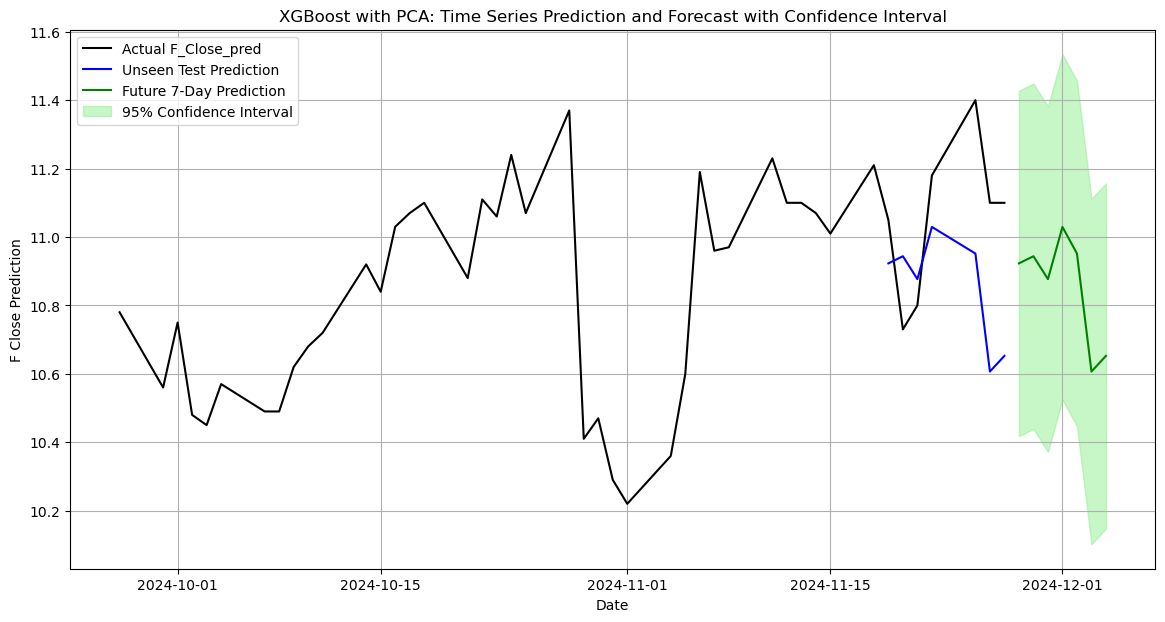

In [25]:

# Step 7: Optional: Apply early stopping manually to the best model after tuning
best_xgb_model.fit(
    X_train_val, y_train_val,
    eval_set=[(X_unseen_test, y_unseen_test)],
    # eval_metric="rmse",
    # early_stopping_rounds=10,
    verbose=False
)

# Step 8: Predict on the last week (unseen test data)
y_unseen_pred = best_xgb_model.predict(X_unseen_test)
mse_unseen = mean_squared_error(y_unseen_test, y_unseen_pred)
print(f"Unseen Test MSE: {mse_unseen}")

# Step 9: Forecast the next 7 days with a confidence interval
future_7_days = X_pca[-7:]  # Use the last week for forecasting
future_predictions = best_xgb_model.predict(future_7_days)

# Calculate confidence interval (simple approximation based on prediction standard deviation)
std_dev = np.std(y_unseen_pred - y_unseen_test)
upper_bound = future_predictions + (1.96 * std_dev)
lower_bound = future_predictions - (1.96 * std_dev)

# Plot the results
plt.figure(figsize=(14, 7))
# Actual data
plt.plot(df_last_2_months['Date'], y, label="Actual F_Close_pred", color='black')
# Predictions on unseen test
plt.plot(df_last_2_months['Date'].iloc[-7:], y_unseen_pred, label="Unseen Test Prediction", color='blue')
# Future forecast
future_dates = pd.date_range(df_last_2_months['Date'].iloc[-1] + pd.Timedelta(days=1), periods=7)
plt.plot(future_dates, future_predictions, label="Future 7-Day Prediction", color='green')
plt.fill_between(future_dates, lower_bound, upper_bound, color='lightgreen', alpha=0.5, label="95% Confidence Interval")

plt.xlabel("Date")
plt.ylabel("F Close Prediction")
plt.title("XGBoost with PCA: Time Series Prediction and Forecast with Confidence Interval")
plt.legend()
plt.grid(True)
plt.show()


In [26]:
results = []

# Retrieve the best model from cross-validation
best_xgb_model = xgb_cv.best_estimator_
best_mse = -xgb_cv.best_score_

# Fit the best model to the entire training and validation set
best_xgb_model.fit(X_train_val, y_train_val)

# Predictions on the training data
y_pred_train = best_xgb_model.predict(X_train_val)
residuals = y_train_val - y_pred_train

# Calculate the sample size and sum of squared errors
n = len(y_train_val)  # Sample size
sse = np.sum(residuals**2)

# Approximate number of parameters for XGBoost (trees * depth)
p = best_xgb_model.get_params()['n_estimators'] * best_xgb_model.get_params()['max_depth']

# Calculate AIC, BIC, and AICc
aic = n * np.log(sse / n) + 2 * p
bic = n * np.log(sse / n) + p * np.log(n)
aicc = aic + (2 * p * (p + 1)) / (n - p - 1)

# Store results in a dictionary
results.append({
    'Model': 'XGBoost',
    'Best Parameters': xgb_cv.best_params_,
    'Best MSE': best_mse,
    'AIC': aic,
    'BIC': bic,
    'AICc': aicc
})

# Convert results list to DataFrame for display
results_df = pd.DataFrame(results)

# Display the table
print("Grid Search Results with MSE, AIC, BIC, and AICc for XGBoost:")
print(results_df)

Grid Search Results with MSE, AIC, BIC, and AICc for XGBoost:
     Model                                    Best Parameters  Best MSE  \
0  XGBoost  {'colsample_bytree': 0.6, 'gamma': 0, 'learnin...  0.081036   

           AIC         BIC        AICc  
0  3716.492745  6938.32857 -358.863671  


In [27]:
# Step 4: Collect MSE and best parameters for XGBoost in a table
results = pd.DataFrame({
    'Model': ['XGBoost'],
    'Best Parameters': [xgb_cv.best_params_],
    'Best MSE': [-xgb_cv.best_score_]  # Convert negative MSE back to positive
})

# Display the table
print("Grid Search Results with MSE for XGBoost Regression:")
print(results)

# Step 5: Choose the best XGBoost model based on the lowest MSE
best_xgb_model = xgb_cv.best_estimator_
print(f"Best XGBoost model: {best_xgb_model}, MSE: {-xgb_cv.best_score_}")

# Optional: Apply early stopping manually to the best model after tuning
best_xgb_model.fit(
    X_train_val, y_train_val,
    eval_set=[(X_unseen_test, y_unseen_test)],
    # eval_metric="rmse",
    # early_stopping_rounds=10,
    verbose=False
)

Grid Search Results with MSE for XGBoost Regression:
     Model                                    Best Parameters  Best MSE
0  XGBoost  {'colsample_bytree': 0.6, 'gamma': 0, 'learnin...  0.081036
Best XGBoost model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...), MSE: 0.08103649598090983


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [28]:
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Step 6: Predict on the last week (unseen test data)
y_unseen_pred = best_xgb_model.predict(X_unseen_test)
mse_unseen = mean_squared_error(y_unseen_test, y_unseen_pred)
print(f"Unseen Test MSE (XGBoost): {mse_unseen}")

# Step 7: Forecast the next 7 days with a confidence interval
# Note: This assumes X_transformed contains the transformed full dataset for the past 2 months
future_7_days = X_transformed[-7:]  # Use the last 7 days of transformed data for forecasting
future_predictions = best_xgb_model.predict(future_7_days)

# Calculate confidence interval (simple approximation based on prediction standard deviation)
std_dev = np.std(y_unseen_pred - y_unseen_test)  # Standard deviation of residuals
upper_bound = future_predictions + (1.96 * std_dev)
lower_bound = future_predictions - (1.96 * std_dev)

# Plot the results
plt.figure(figsize=(14, 7))

# Plot actual observed values
plt.plot(df_last_2_months['Date'], y, label="Actual F_Close_pred", color='black')

# Plot unseen test predictions for the last week
plt.plot(df_last_2_months['Date'].iloc[-7:], y_unseen_pred, label="Unseen Test Prediction", color='blue')

# Plot future forecast for the next 7 days
future_dates = pd.date_range(df_last_2_months['Date'].iloc[-1] + pd.Timedelta(days=1), periods=7)
plt.plot(future_dates, future_predictions, label="Future 7-Day Prediction", color='green')

# Plot confidence interval
plt.fill_between(future_dates, lower_bound, upper_bound, color='lightgreen', alpha=0.5, label="95% Confidence Interval")

# Labels and title
plt.xlabel("Date")
plt.ylabel("F Close Prediction")
plt.title("XGBoost Time Series Prediction and Forecast with Confidence Interval")
plt.legend()
plt.grid(True)
plt.show()

Unseen Test MSE (XGBoost): 0.10498245353924843


ValueError: Feature shape mismatch, expected: 11, got 148

In [ ]:
import numpy as np
import pandas as pd

# Assuming y_unseen_pred and future_predictions have been calculated in prior steps

# Create a DataFrame to compare actual values and predicted values for the last two weeks

# Extract dates for the last two weeks
dates_last_two_weeks = df_last_2_months['Date'].iloc[-14:]

# Extract actual values for the last two weeks
actual_values_last_two_weeks = y.iloc[-14:]

# Initialize predicted values with NaN for the first week of the two-week window
predicted_values_last_two_weeks = [np.nan] * 7 + list(y_unseen_pred)

# Create a DataFrame with actual and predicted values
comparison_df = pd.DataFrame({
    'Date': dates_last_two_weeks.values,
    'Actual F_Close_pred': actual_values_last_two_weeks.values,
    'Predicted F_Close_pred': predicted_values_last_two_weeks
})

# Reset index for a cleaner display
comparison_df.reset_index(drop=True, inplace=True)

# Generate future dates for the forecasted 7 days
future_dates = pd.date_range(comparison_df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=7)

# Create a DataFrame for the forecasted data with NaN for actual values and predictions in predicted column
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Actual F_Close_pred': [np.nan] * 7,  # No actual data for the future
    'Predicted F_Close_pred': future_predictions  # Forecasted predictions from XGBoost
})

# Append the forecasted data to the original comparison_df
comparison_df_with_forecast = pd.concat([comparison_df, forecast_df], ignore_index=True)

# Display the updated table with both the last week's predictions and the future forecast
print(comparison_df_with_forecast)

         Date  Actual F_Close_pred  Predicted F_Close_pred
0  2024-10-09                10.62                     NaN
1  2024-10-10                10.68                     NaN
2  2024-10-11                10.72                     NaN
3  2024-10-14                10.92                     NaN
4  2024-10-15                10.84                     NaN
5  2024-10-16                11.03                     NaN
6  2024-10-17                11.07                     NaN
7  2024-10-18                11.10               11.030890
8  2024-10-21                10.88               10.954867
9  2024-10-22                11.11               11.034644
10 2024-10-23                11.06               11.028923
11 2024-10-24                11.24               11.036556
12 2024-10-25                11.07               11.003949
13 2024-10-28                11.37               11.031405
14 2024-10-29                  NaN               11.030890
15 2024-10-30                  NaN               10.9548

## Backtesting

In [ ]:
def plot_backtesting_results(backtest_results, df):
    """
    Plot fitted model predictions vs real data for each backtest.
    """
    for idx, row in backtest_results.iterrows():
        # Extract the test period
        test_start = row['Test Start']
        test_end = row['Test End']

        # Filter the actual data for the test period
        test_data = df[(df['Date'] >= test_start) & (df['Date'] <= test_end)]
        y_test = test_data['F_Close_pred'].values

        # Extract predictions for the test period
        y_pred = row['Predictions']

        # Plot the results
        plt.figure(figsize=(10, 6))
        plt.plot(test_data['Date'], y_test, label='Actual', marker='o', linestyle='-', color='blue')
        plt.plot(test_data['Date'], y_pred, label='Predicted', marker='x', linestyle='--', color='red')
        plt.title(f"Backtesting Results: {row['Train Start']} to {row['Test End']}")
        plt.xlabel('Date')
        plt.ylabel('F_Close_pred')
        plt.legend()
        plt.grid(True)
        plt.show()

def rolling_backtesting_xgboost_pca(df, num_backtests=5, window_size_months=2, test_days=7, n_pca_components=11):
    """
    Perform rolling backtesting with PCA and XGBoost-based regression models.
    """
    backtest_results = []
    start_idx = 0
    total_data_points = len(df)
    backtest_count = 0  # To count the number of backtests performed

    while (
        start_idx + window_size_months * 30 + test_days <= total_data_points 
        and backtest_count < num_backtests
    ):
        # Calculate start and end indices for training and testing
        train_start_idx = start_idx
        train_end_idx = train_start_idx + window_size_months * 30
        test_start_idx = train_end_idx
        test_end_idx = test_start_idx + test_days

        # Prepare the training and testing datasets
        train_data = df.iloc[train_start_idx:train_end_idx]
        test_data = df.iloc[test_start_idx:test_end_idx]

        # Features and target for training
        X_train = train_data.drop(columns=['Date', 'F_Close_pred', 'F_Bollinger_Upper', 'F_Bollinger_Lower'])
        y_train = train_data['F_Close_pred']

        # Features and target for testing
        X_test = test_data.drop(columns=['Date', 'F_Close_pred', 'F_Bollinger_Upper', 'F_Bollinger_Lower'])
        y_test = test_data['F_Close_pred']

        # Preprocess the data
        scaler = StandardScaler()
        power_transformer = PowerTransformer()
        X_train_scaled = scaler.fit_transform(X_train)
        X_train_transformed = power_transformer.fit_transform(X_train_scaled)
        X_test_scaled = scaler.transform(X_test)
        X_test_transformed = power_transformer.transform(X_test_scaled)

        # Apply PCA
        pca = PCA(n_components=n_pca_components)
        X_train_pca = pca.fit_transform(X_train_transformed)
        X_test_pca = pca.transform(X_test_transformed)

        # Set up parameter grid for XGBoost hyperparameter tuning
        xgb_params = {
            'n_estimators': [200, 300, 400],
            'learning_rate': [0.01, 0.005],
            'max_depth': [3, 5, 7],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'gamma': [0, 0.1, 0.2],
            'min_child_weight': [1, 5, 10]
        }

        # Initialize XGBoost Regressor
        xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)

        # TimeSeriesSplit for cross-validation
        tscv = TimeSeriesSplit(n_splits=5)

        # GridSearchCV with TimeSeriesSplit
        xgb_cv = GridSearchCV(xgb_reg, xgb_params, scoring='neg_mean_squared_error', cv=tscv)
        xgb_cv.fit(X_train_pca, y_train)

        # Get the best model for this training set
        best_model = xgb_cv.best_estimator_

        # Train the best model on the training data
        best_model.fit(X_train_pca, y_train)

        # Predict the next 7 days
        y_pred = best_model.predict(X_test_pca)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        # Append results to backtest_results
        backtest_results.append({
            'Train Start': train_data['Date'].iloc[0],
            'Train End': train_data['Date'].iloc[-1],
            'Test Start': test_data['Date'].iloc[0],
            'Test End': test_data['Date'].iloc[-1],
            'Best Parameters': xgb_cv.best_params_,
            'MSE': mse,
            'RMSE': rmse,
            'R²': r2,
            'Predictions': y_pred
        })

        # Increment the counter and move the window forward by the test period
        backtest_count += 1
        start_idx += 200

    return pd.DataFrame(backtest_results)

# Perform rolling backtesting for XGBoost with PCA
backtest_results_xgboost_pca = rolling_backtesting_xgboost_pca(df, num_backtests=5)

# Display results
print("Rolling Backtesting Results for XGBoost with PCA (5 Iterations):")
print(backtest_results_xgboost_pca)

# Plot the results
plot_backtesting_results(backtest_results_xgboost_pca, df)


KeyboardInterrupt: 